In [6]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random as python_random
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import librosa
import librosa.display
import matplotlib.pyplot as plt
import os
import shutil
from datasets import load_dataset
from tqdm.auto import tqdm

In [7]:
seed_value = 123  # Esta es una semilla ejemplo, puedes elegir tu propio número

np.random.seed(seed_value)  # numpy
python_random.seed(seed_value)  # Python's built-in random library
tf.random.set_seed(seed_value)  # tensorflow

In [8]:
# dataset = load_dataset("ccmusic-database/music_genre", name="default")
# print(len(dataset["train"]))
# print(len(dataset["validation"]))
# print(len(dataset["test"]))

In [9]:
"""
# Crear las carpetas si no existen
base_dir = 'data2'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
validation_dir = os.path.join(base_dir, 'validation')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)

# Función para guardar las imágenes en la estructura de directorios adecuada
def save_images(dataset, partition):
    for index, data in enumerate(tqdm(dataset)):
        label = str(data['fst_level_label'])
        partition_dir = {
            'train': train_dir,
            'test': test_dir,
            'validation': validation_dir
        }[partition]
        label_dir = os.path.join(partition_dir, label)
        os.makedirs(label_dir, exist_ok=True)
        image_path = os.path.join(label_dir, f"{partition}_{index}.png")
        data['mel'].save(image_path)  # Guardar la imagen mel como PNG
        print(f"{partition}_{index}.png")

# Guardar las imágenes para cada partición
save_images(dataset['train'], 'train')
save_images(dataset['test'], 'test')
save_images(dataset['validation'], 'validation')
"""

'\n# Crear las carpetas si no existen\nbase_dir = \'data2\'\ntrain_dir = os.path.join(base_dir, \'train\')\ntest_dir = os.path.join(base_dir, \'test\')\nvalidation_dir = os.path.join(base_dir, \'validation\')\n\nos.makedirs(train_dir, exist_ok=True)\nos.makedirs(test_dir, exist_ok=True)\nos.makedirs(validation_dir, exist_ok=True)\n\n# Función para guardar las imágenes en la estructura de directorios adecuada\ndef save_images(dataset, partition):\n    for index, data in enumerate(tqdm(dataset)):\n        label = str(data[\'fst_level_label\'])\n        partition_dir = {\n            \'train\': train_dir,\n            \'test\': test_dir,\n            \'validation\': validation_dir\n        }[partition]\n        label_dir = os.path.join(partition_dir, label)\n        os.makedirs(label_dir, exist_ok=True)\n        image_path = os.path.join(label_dir, f"{partition}_{index}.png")\n        data[\'mel\'].save(image_path)  # Guardar la imagen mel como PNG\n        print(f"{partition}_{index}.png

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Definir las rutas a tus directorios
base_dir = './data2'  # Ruta base donde se encuentran tus datos
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Configuración de la generación de datos con aumento de datos en el conjunto de entrenamiento
train_datagen = ImageDataGenerator(rescale=1./255)  # Normaliza las imágenes
validation_datagen = ImageDataGenerator(rescale=1./255)  # Normaliza las imágenes

# Preparar el flujo de datos de entrenamiento
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),  # Cambiar a las dimensiones que espera tu modelo
    batch_size=32,
    class_mode='binary')  # 'binary' para clasificación binaria, 'categorical' para multiclase

# Preparar el flujo de datos de validación
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')  # 'binary' para clasificación binaria, 'categorical' para multiclase

# Preparar el flujo de datos de prueba
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',  # 'binary' para clasificación binaria, 'categorical' para multiclase
    shuffle=False)  # No mezclar las imágenes de prueba

Found 1370 images belonging to 2 classes.
Found 171 images belonging to 2 classes.
Found 172 images belonging to 2 classes.


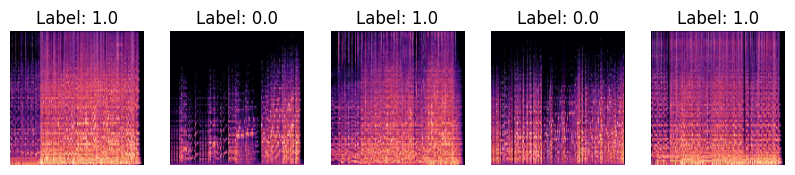

Clases del generador de entrenamiento: {'0': 0, '1': 1}
Número total de muestras de entrenamiento: 1370
Número total de muestras de validación: 171
Número total de muestras de prueba: 172
Dimensiones del lote de imágenes: (32, 150, 150, 3)
Dimensiones del lote de etiquetas: (32,)


In [12]:
# Visualización de algunas imágenes del generador de entrenamiento
import matplotlib.pyplot as plt

# Extraer un lote de imágenes y etiquetas del generador de entrenamiento
batch_images, batch_labels = next(train_generator)

# Mostrar las primeras 5 imágenes del lote
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(batch_images[i])
    plt.title('Label: {}'.format(batch_labels[i]))
    plt.axis('off')
plt.show()

# Inspección de las clases asignadas por el generador
print("Clases del generador de entrenamiento:", train_generator.class_indices)

# Verificación del número total de muestras en cada conjunto de datos
print("Número total de muestras de entrenamiento:", train_generator.samples)
print("Número total de muestras de validación:", validation_generator.samples)
print("Número total de muestras de prueba:", test_generator.samples)

# Evaluación del flujo de datos del generador de entrenamiento
for images, labels in train_generator:
    print("Dimensiones del lote de imágenes:", images.shape)
    print("Dimensiones del lote de etiquetas:", labels.shape)
    # Puedes agregar más comprobaciones aquí si es necesario
    break  # Detener después de un solo lote para la demostración


In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras import backend as K
import numpy as np
from focal_loss import BinaryFocalLoss

num_labels = len(np.unique(train_generator.classes))  # Número de clases en el conjunto de entrenamiento

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),  # Dropout para reducir el sobreajuste
    layers.Dense(512, activation='relu'),
    layers.Dense(num_labels if num_labels > 2 else 1, 
                 activation='sigmoid' if num_labels == 2 else 'softmax')    
])


# Definir la métrica F1 para la clasificación binaria
def f1_score(y_true, y_pred):
    y_pred = K.round(y_pred)  # Redondear las predicciones para calcular la métrica
    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2 * p * r / (p + r + K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

# Seleccionar la función de pérdida según el problema
loss_function = 'binary_crossentropy' if num_labels == 2 else 'sparse_categorical_crossentropy'

# Compilar el modelo
model.compile(optimizer='adam',
              loss=BinaryFocalLoss(gamma=2),
              metrics=['accuracy', f1_score])

# Definir el callback de EarlyStopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

# Entrenar el modelo
history = model.fit(train_generator,
                    epochs=700,
                    validation_data=validation_generator,
                    callbacks=[callback])

# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy, test_f1 = model.evaluate(test_generator)
print('Test accuracy:', test_accuracy)
print('Test F1 score:', test_f1)

c:\Users\Usuario\anaconda3\envs\aine\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/700
43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 400ms/step - accuracy: 0.7456 - f1_score: 0.7430 - loss: 0.1998 - val_accuracy: 0.7895 - val_f1_score: 0.7827 - val_loss: 0.1357
Epoch 2/700
43/43 ━━━━━━━━━━━━━━━━━━━━ 19s 395ms/step - accuracy: 0.7645 - f1_score: 0.7646 - loss: 0.1415 - val_accuracy: 0.7895 - val_f1_score: 0.8026 - val_loss: 0.1321
Epoch 3/700
43/43 ━━━━━━━━━━━━━━━━━━━━ 22s 474ms/step - accuracy: 0.7612 - f1_score: 0.7611 - loss: 0.1435 - val_accuracy: 0.7895 - val_f1_score: 0.8026 - val_loss: 0.1404
Epoch 4/700
43/43 ━━━━━━━━━━━━━━━━━━━━ 22s 468ms/step - accuracy: 0.7561 - f1_score: 0.7561 - loss: 0.1445 - val_accuracy: 0.7895 - val_f1_score: 0.8026 - val_loss: 0.1338
Epoch 5/700
43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 458ms/step - accuracy: 0.7669 - f1_score: 0.7670 - loss: 0.1409 - val_accuracy: 0.7895 - val_f1_score: 0.7926 - val_loss: 0.1343
Epoch 6/700
43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 452ms/step - accuracy: 0.7640 - f1_score: 0.7639 - loss: 0.1407 - val_accuracy: 0.7895 - val_f1_s